# GDA – Übung 4: Vsualsierung

## Einleitung
In der heutigen Übung betrachten wir die Methoden *Kernel Density Estimation (KDE)* und *Inverse Distance Weighting (IDW)*. Während Erstere ein Verfahren zur Schätzung der Wahrscheinlichkeitsverteilung einer Zufallsvariablen ist, ist Letzere eine in der GIS-Welt häufig angewandte Interpolationsmethode, um Werte zwischen bekannten Messwerten zu interpolieren. Es geht wie häufig in der Welt hauptsächlich um das erste geographische Gesetz nach Waldo Tobler:  
> Everything is related to everything else, but near things are more related than distant things.
>
> -- <cite>Tobler W., (1970) "A computer movie simulating urban growth in the Detroit region". Economic Geography, 46(Supplement): 234–240.</cite>

Angenommen, es existiert ein räumliches Phänomen, aber Sie sind (aus wirtschaftlichen oder sonstigen Gründen) nur imstande, einige Punkte zu messen und daher eine Stichprobe zu nehmen, so müssen Sie die dazwischenliegenden Werte interpolieren. Das Ziel der heutigen Übung ist es, beide Verfahren selbstständig zu implementieren. Dabei sollen Sie auch unterschiedliche Kernels anwenden und deren Auswirkungen auf die resultierenden Karten untersuchen. 

### Dateien
Wir verwenden für diese Aufgabe den *Meuse*-Datensatz (siehe http://spatial-analyst.net/book/meusegrids), der von Burrough und McDonnel 1998 erstellt wurde. Der Datensatz umfasst vier Schwermetalle im Oberboden (Einheit: **ppm**) und andere Kovariaten, die entlang des Flusses *Meuse* in der oberen Bodenschicht gemessen wurde. Es scheint so, als ob der Fluss die mit Schwermetall belasteten Sedimente flussabwärts transportieren und entlang des Flusses und im Flussdelta ablagern würde. Im Sinne von Tobler's First Law of Geography dürfte man deshalb erwarten, dass die Schwermetallwerte im ganzen Untersuchungsgebiet nicht gleich verteilt sind.
> -- <cite>P.A. Burrough, R.A. McDonnell, 1998. Principles of Geographical Information Systems. Oxford University Press.</cite>

In dieser Aufgabe erhalten Sie die folgenden Dateien:
* `meuse.json` ein JSON mit Messwerten mit Schwermetallen, die an verschiedenen Puntken entlang des Flusses Meuse aufgezeichnet wurden. Darin sind u.a. folgende Attribute enthalten:
  * cadmium: Cd-Gehalt in ppm
  * copper: Cu-Gehalt in ppm
  * lead: Pb-Gehalt in ppm
  * zinc: Zn-Gehalt in ppm
  * dist: Distanz zum Ufer der Meuse
  * ffreq: jährliche Häufigkeit von Überflutungen
  * soil: 
* `mask.tif` ein leeres Raster im Flussdelta des Untersuchungsgebiet in einer Auflösung von 25 m. Alle Pixel mit dem Wert 1 kennzeichnen Pixel innerhalb des Studiengebiets. Alle anderen Werte sind dem `nodata`-Wert zugeordnet und gehören nicht zum Untersuchungsgebiet.
* `topomap2m` eine topographische Karte des Untersuchungsgebiets in einer Auflösung von 2 m. Diese dient Ihnen zur Übersicht.

Die Dateien sind allesamt im folgenden projizierten CRS gespeichert: **proj4: +init=epsg:28992**


## Hilfsfunktionen

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import fiona
import math
import random
from pprint import pprint
import pandas as pd
import geopandas as gpd
import json
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.transform import Affine
from sklearn.neighbors import NearestNeighbors

In [2]:
def show_raster_map_grid(array_list, mask=None, data_coordinates=None, dim=None):
    """
    Loads and plots the raster data
    :param array: The array that should be visualized
    :return:
    """
    
    if dim is None:
        dim = (1, len(array_list))
    # show image with special trick for colorbar (https://stackoverflow.com/questions/32462881/add-colorbar-to-existing-axis)
    fig, axes = plt.subplots(dim[0], dim[1], figsize=(20, 20))
    
    try:
        axes[0]
    except TypeError:
        axes = (axes,)
    
    
    for ix, ax in enumerate(axes):
    
        array = array_list[ix]
        
        if mask is None:
            mask = np.ones(array.shape)
        
        im = ax.imshow(array*mask, cmap='hot')  
        
        # if provided, plot the query points.
        # Query points first have to be projected into the image space
        if data_coordinates is not None:
            rows = []
            cols = []
            for i in range(len(data_coordinates)):
                #https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.rowcol
                rowcol_tuple = rasterio.transform.rowcol(fwd, data_coordinates[i][0], data_coordinates[i][1])
                rows.append(rowcol_tuple[0])
                cols.append(rowcol_tuple[1]) 


            ax.scatter(cols, rows, color='b', s=30, marker='x')
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

    plt.show()
        
    
def compute_distance(coords_1, coords_2):
    """
    Computes the euclidean distance between two coordinates given that they are represented by projected coordinates
    :param coord_1: A tuple or list containing a coordinate pair
    :param coord_2: A tuple or list containing a coordinate pair
    :return: The distance given in the same length dimension as they are stored in the used file
    """
    delta_y = coords_1[0] - coords_2[0]
    delta_x = coords_1[1] - coords_2[1]
    return math.sqrt(math.pow(delta_x, 2) + math.pow(delta_y, 2))

def get_transform(xmax, xmin, ymax, ymin, nb_pixels_x, nb_pixels_y):

    # define transformation function
    resx = (xmax - xmin) / nb_pixels_x
    resy = (ymax - ymin) / nb_pixels_y
    fwd = Affine.translation(xmin - resx / 2, ymin - resy / 2) * Affine.scale(resx, resy)

    return fwd


# Daten laden und wichtige Variablen definieren

In [3]:
# Define important paths
meuse_file = os.path.join('data', 'meuse.json')
mask_file = os.path.join('data', 'mask.tif')
topomap_file = os.path.join('data', 'topomap2m.tif')

# Load the data sets
meuse = gpd.read_file(meuse_file)
mask = rasterio.open(mask_file, 'r')
topomap = rasterio.open(topomap_file, 'r')

# Read the first band of the ones raster
mask_array = mask.read(1)
mask_array[mask_array <= 0] = np.nan


# Determine other important settings from the input raster
no_data = mask.profile['nodata']
fwd = mask.profile['transform']
crs = mask.profile['crs']

### Look at the data
There are several datasets available for this exercise:
- __topomap__: A map of the respective region. The every channel $i \in [1,2,3]$ can be retrieved as a numpy array using `topomap.read(i)`. 
- __mask_array__: A binary mask of the area where data is available. The data is given as numpy array (matrix)
- __meuse__: The available measurements. The data is given as collection of dictionaries. A single entry can be retrieved using `meuse[i]` where `i` is the sample id. All sample ids can be printed using: `print(list(meuse.keys()))`


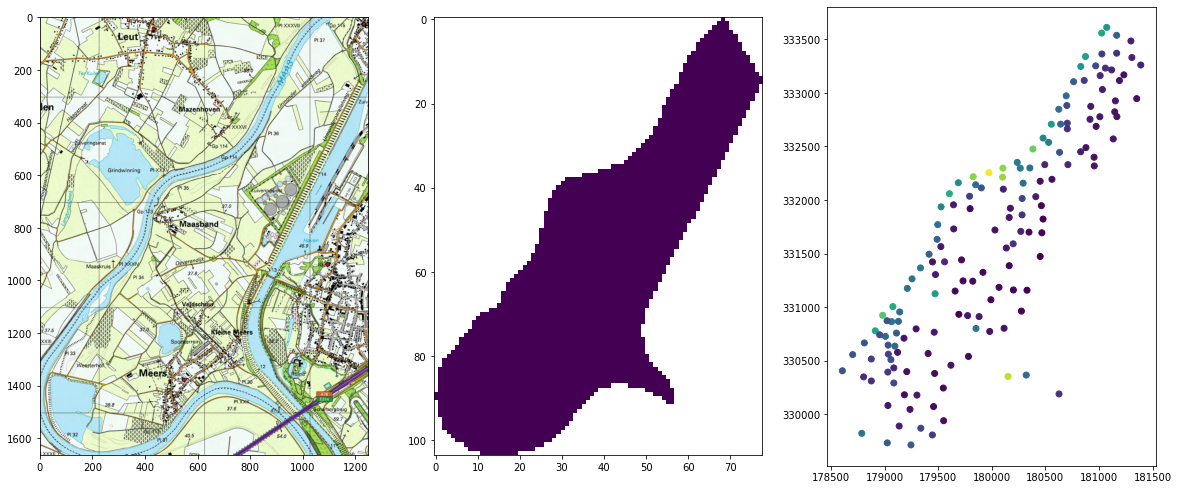

In [4]:
rgb_array = [topomap.read(i+1) for i in range(3)]

fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(np.stack(rgb_array, axis=-1), cmap='gray')
ax[1].imshow(mask_array)
meuse.plot(column='zinc', ax=ax[2])

### plot measurement data using coordinates and in pixel space 
Beachten Sie vor allem die Unterschiedlichen Achsenbeschriftungen

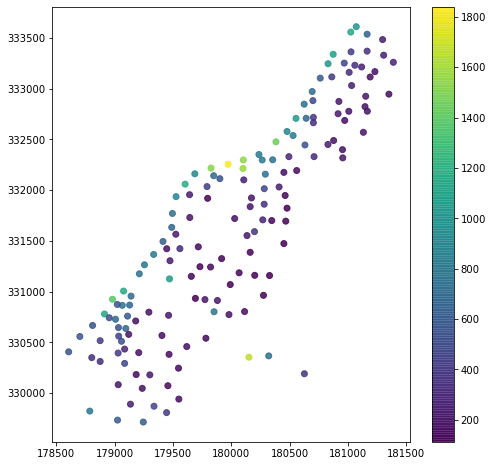

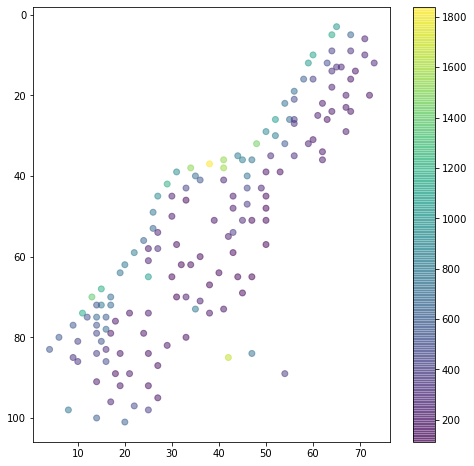

In [5]:
# plotting with the coordinates
coords_x = meuse.geometry.x
coords_y = meuse.geometry.y
zinc_data =  meuse['zinc'].values

plt.figure(figsize=(8,8))
plt.scatter(coords_x, coords_y, alpha=0.85, c=zinc_data)
plt.colorbar()

# plotting in "pixel-space" using the rasterio rowcol transform
plt.figure(figsize=(8,8))
pixel_x = []
pixel_y = []
for i in range(len(coords_x)):
    rowcol_tuple = rasterio.transform.rowcol(fwd, coords_x[i], coords_y[i])
    pixel_x.append(rowcol_tuple[1])
    pixel_y.append(rowcol_tuple[0])

plt.scatter(pixel_x, pixel_y, alpha=0.5, c=zinc_data, )
plt.colorbar()
plt.gca().invert_yaxis()



### Daten in einfachem Format vorbereiten
- __data_coordinates__ ist eine Liste mit (x,y) Koordinatentupeln.
- __zinc_data__ ist eine Liste mit den Zinkwerten die an den Punkten gemessen wurden.

Die einzelnen Einträge der beiden Variablen gehören jeweils zusammen. Beispiel:
data_coordinates[i] sind die Koordinaten an denen zinc_data[i] gemessen wurde.

In [6]:

data_coordinates = list(zip(coords_x, coords_y))
data_coordinates

[(181072.0, 333611.0),
 (181025.0, 333558.0),
 (181165.0, 333537.0),
 (181298.0, 333484.0),
 (181307.0, 333330.0),
 (181390.0, 333260.0),
 (181165.0, 333370.0),
 (181027.0, 333363.0),
 (181060.0, 333231.0),
 (181232.0, 333168.0),
 (181191.0, 333115.0),
 (181032.0, 333031.0),
 (180874.0, 333339.0),
 (180969.0, 333252.0),
 (181011.0, 333161.0),
 (180830.0, 333246.0),
 (180763.0, 333104.0),
 (180694.0, 332972.0),
 (180625.0, 332847.0),
 (180555.0, 332707.0),
 (180642.0, 332708.0),
 (180704.0, 332717.0),
 (180704.0, 332664.0),
 (181153.0, 332925.0),
 (181147.0, 332823.0),
 (181167.0, 332778.0),
 (181008.0, 332777.0),
 (180973.0, 332687.0),
 (180916.0, 332753.0),
 (181352.0, 332946.0),
 (181133.0, 332570.0),
 (180878.0, 332489.0),
 (180829.0, 332450.0),
 (180954.0, 332399.0),
 (180956.0, 332318.0),
 (180710.0, 332330.0),
 (180632.0, 332445.0),
 (180530.0, 332538.0),
 (180478.0, 332578.0),
 (180383.0, 332476.0),
 (180494.0, 332330.0),
 (180561.0, 332193.0),
 (180451.0, 332175.0),
 (180410.0,

In [7]:
zinc_data =  meuse['zinc'].values
zinc_data

array([1022., 1141.,  640.,  257.,  269.,  281.,  346.,  406.,  347.,
        183.,  189.,  251., 1096.,  504.,  326., 1032.,  606.,  711.,
        735., 1052.,  673.,  402.,  343.,  218.,  200.,  194.,  207.,
        180.,  240.,  180.,  208.,  198.,  250.,  192.,  213.,  321.,
        569.,  833.,  906., 1454.,  298.,  167.,  176.,  258.,  746.,
        746.,  464.,  365.,  282.,  375.,  222.,  812., 1548., 1839.,
       1528.,  933.,  432.,  550., 1571., 1190.,  907.,  761.,  659.,
        643.,  801.,  784., 1060.,  119.,  778.,  703.,  676.,  793.,
        685.,  593.,  549.,  680.,  539.,  560., 1136., 1383., 1161.,
       1672.,  765.,  279.,  241.,  317.,  545.,  505.,  420.,  332.,
        400.,  553.,  577.,  155.,  224.,  180.,  226.,  186.,  198.,
        187.,  199.,  157.,  203.,  143.,  136.,  117.,  113.,  130.,
        192.,  240.,  221.,  140.,  128.,  166.,  191.,  232.,  203.,
        722.,  210.,  198.,  139.,  253.,  703.,  832.,  262.,  142.,
        119.,  152.,

# Aufgabe 1: KDE mit Gauss Kernel
Implementieren in der Funktion `kde` eine Kernel Density Estimation mit einem Gauss Kernel. Orientieren Sie sich dafür anhand der folgenden Formeln:

$$f_h(x) = \frac{1}{n\cdot h} \sum^n_{i=n}K(\frac{d(x,x_i)}{h})$$


$$K(u) = \frac{1}{\sqrt{2\pi}}\exp(-\frac{u^2}{2})$$

Verwenden sie die Zinkkonzentration als Gewichtung. Wo befinden sich Ihrer Meinung nach die höchsten Konzentrationen an Zink?




### Vorgehen:
Sehen Sie sich die Hauptfunktion, hier wird die Funktion `kde` mit den Pixelkoordinaten als Eingangswert zugegriffen. Vervollständigen Sie die Funktion `kde`, sodass für jeden Eingangspixel der Einfluss aller Messwerte basierend auf der obigen Formel berechnet wird.

- 
* Für jeden Pixel, iteriere durch alle Datenpunkte
* Finde heraus, wieviel jeder Datenpunkte zu dem Wert des Pixels beiträgt
* Für die Gewichtung kann man unterschiedliche Methoden verwenden. Wir betrachte Kernel Density Estimation (KDE) und Inverse Distance Weighting (IDW).

#### Hinweise:
- mask_array beschreibt die Ausdehnung ihres Studiengebiets im Pixelkoordinaten
- Vergessen Sie nicht den Eingangspixel in den Koordinatenraum zu projezieren um die Distanz zu berechnen. Mit der durch rasterio vorgegeben transformation (`fwd`) ist das bereits implementiert und vorbereitet  (https://rasterio.readthedocs.io/en/latest/quickstart.html#dataset-georeferencing). 

In [8]:
def kde(cell_position, data_coordinates=data_coordinates, data_values=zinc_data, h=100, pixel_to_coords_transform=fwd):
    """
    Computes the kernel density estimate at a cell position. 
    :param pixel_coordinates: A tuple or list containing a coordinate pair in pixel coordinates.
    :param data_points: List of x-y coordinate tuples of the data_values in EPGS:28992
    :param data_values: List of data values used for weighting the results
    :param fwd: The Affine object by which the forward transformation can be executed
    :return: The result that should be written into the corresponding pixel
    """
    # Convert the pixel coordinates to real coordinates by using the fwd transformation
    cell_coordinates = pixel_to_coords_transform * cell_position
    
    
    # Set important values and set n and sum to zero
    running_sum = 0
    
    # Iterate through all points of the point feature data set, compute the weight by using the formula for 
    # the kernel, and sum it up
    n = len(data_values)
    
    for i in range(n):
        u_i = data_values[i]
        d = compute_distance(cell_coordinates, data_coordinates[i])
        u = d / h
        K_u = 1 / math.sqrt(2 * math.pi) * math.exp(-math.pow(u, 2) / 2)
        running_sum +=  K_u * u_i
        
    # Last step of KDE: Apply the formula to the determined sum and return the result
    result = ((1 / (n * h)) * running_sum)
    return result

# test. Wert sollte in etwa bei 3.247539587692823e-86 liegen
kde((0,2), data_coordinates, zinc_data)

3.247539587692823e-86

### Hauptfunktion Aufgabe 1

100%|███████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 109.18it/s]


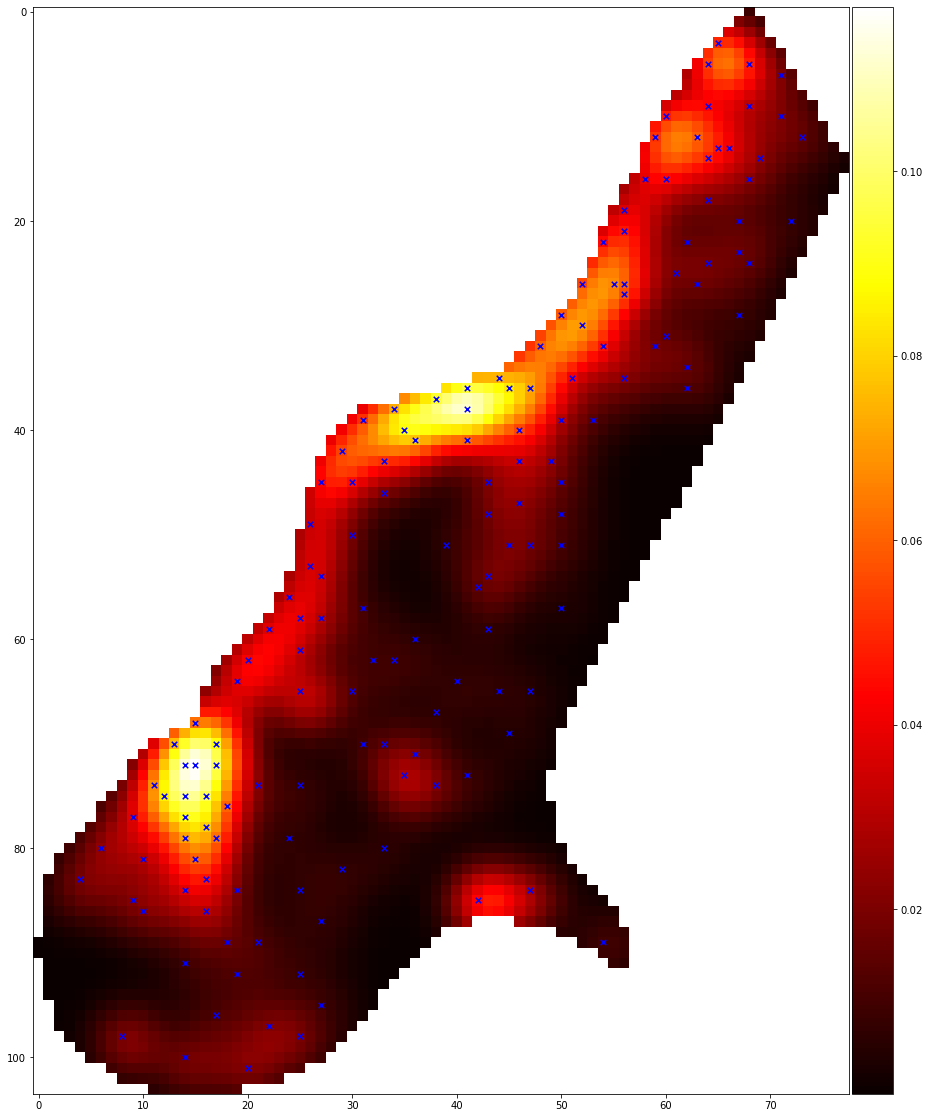

In [9]:
kde_array = np.zeros(mask_array.shape)

# Iterate through the ones array and consider just the values which are not no_data
for y in tqdm(range(mask_array.shape[0])):
    for x in range(mask_array.shape[1]):
        
        if not np.isnan(mask_array[y][x]):
            kde_array[y][x] = kde((x, y))
            
        else:
            kde_array[y][x] = -1
            
show_raster_map_grid([kde_array], mask_array, data_coordinates=data_coordinates)

# Aufgabe 2: Inverse Distance Weighting
Implementieren sie IDW anhand der folgenden Formeln:




$$ u(x) =  \begin{cases} 
      \frac{\sum_{i=1}^n w_i(x)\cdot u_i}{\sum^N_{i=1} w_i(x)} & if d(x,x_i) = 0  \\
      u_i & if d(x,x_i) = 0 
   \end{cases}
$$

$$ w_i(x) = \frac{1}{d(x, x_i)^p}$$



Verwenden sie die Zinkkonzentration als Gewichtung. Wo befinden sich Ihrer Meinung nach die höchsten Konzentrationen an Zink?

In [10]:
def idw(cell_position, data_coordinates=data_coordinates, data_values=zinc_data,  p=2, pixel_to_coords_transform=fwd):
    """
    Computes the kernel density estimate at a cell position. 
    :param pixel_coordinates: A tuple or list containing a coordinate pair in pixel coordinates.
    :param data_points: List of x-y coordinate tuples of the data_values in EPGS:28992
    :param data_values: List of data values used for weighting the results
    :param p: Degree to which the distance fades away
    :param fwd: The Affine object by which the forward transformation can be executed
    :return: The result that should be written into the corresponding pixel
    """
    
    # Convert the pixel coordinates to real coordinates by using the fwd transformation
    cell_coordinates = pixel_to_coords_transform * cell_position
    
    # Set important values and set count and sum to zero
    count = 0
    running_sum = 0
    sum_of_weights = 0
    result = 0
    
    # Iterate through all points of the point feature data set, compute the IDW value by multiplying the 
    # weight with the according value and sum both, the value and just the weights up
    n = len(data_values)
    for i in range(n):
        
        u_i = data_values[i]
        d = compute_distance(cell_coordinates, data_coordinates[i])
                
        if (d==0):
            return u_i
        
        else:
            w_i = math.pow(d, -p)
            sum_of_weights += w_i
            running_sum += w_i * u_i        
    
    # Last step of IDW: Divide the IDW sum by the sum of the weights and return it
    result = running_sum / sum_of_weights
    return result
# Test, value should be close to 518.8726477986377
idw((0,2), data_coordinates, zinc_data)

518.8726477986377

### Hauptfunktion Aufgabe 2
Das Raster wird Pixel für Pixel abgetastet. Wenn ein Pixel innerhalb der Maske liegt, dann wird der jeweilige Werte von KDE und IDW ermittelt und zugewiesen.
Verwenden Sie `kde_array` und `idw_array` um ihre berechneten Werte zu speichern.

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:02<00:00, 51.18it/s]


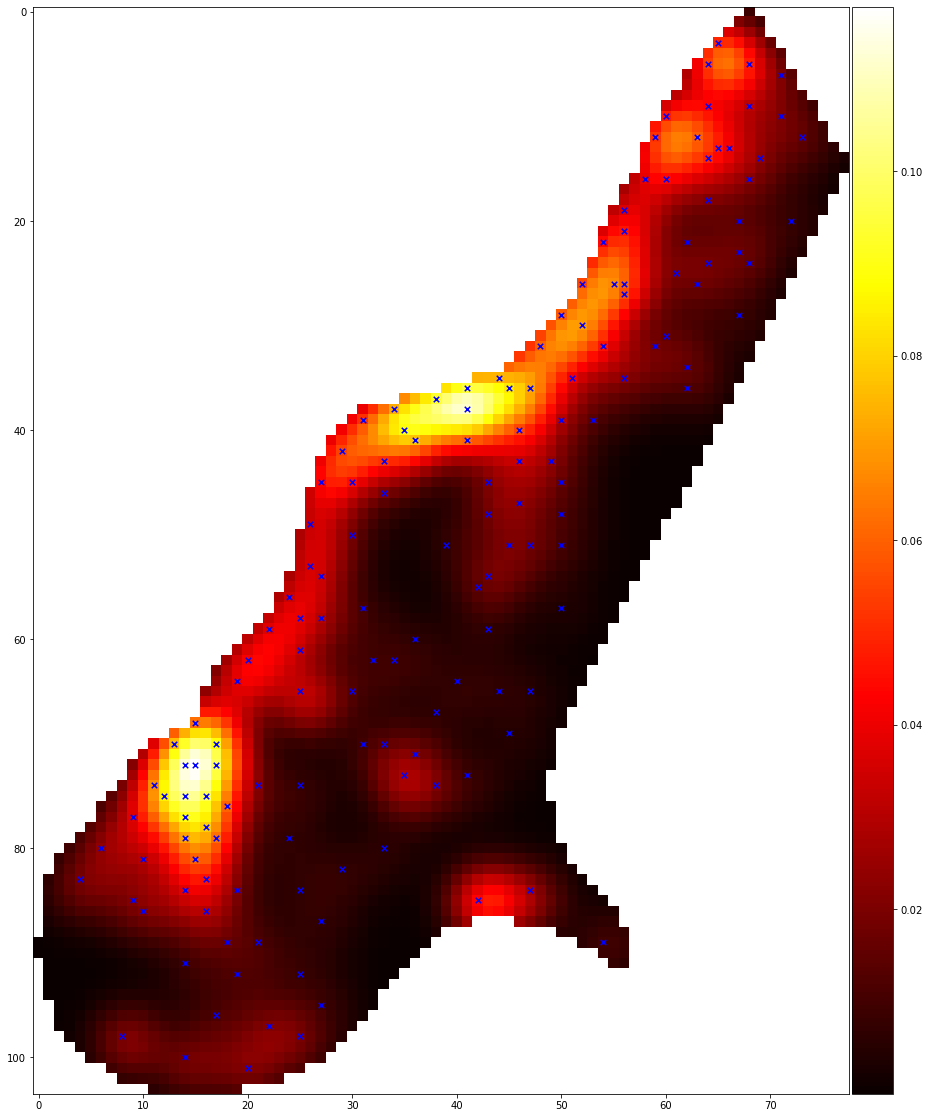

In [11]:
idw_array = np.zeros(mask_array.shape)

# Iterate through the ones array and consider just the values which are not no_data
for y in tqdm(range(mask_array.shape[0])):
    for x in range(mask_array.shape[1]):
        
        if mask_array[y][x] != 0:
            idw_array[y][x] = idw((x, y), p=4)
            
        
        else:
            idw_array[y][x] = -1
            
show_raster_map_grid([kde_array], mask_array, data_coordinates=data_coordinates)

### Aufgabe 3: Vergleich und Verständnis für Hyperparameter
Übergeben Sie der Funktion `show_raster_map_grid` eine Liste mit mehreren Matrizen aus dem Studiengebiet um sie nebeneinander darzustellen und zu vergleichen.
- Was sind die Unterschiede der beiden Methoden?
- Welche würden Sie wofür verwenden? 
- Wenn Sie einen Ort mit einer möglichst geringen Zinkkonzentration suchen, welche Methode ist besser geeignet?

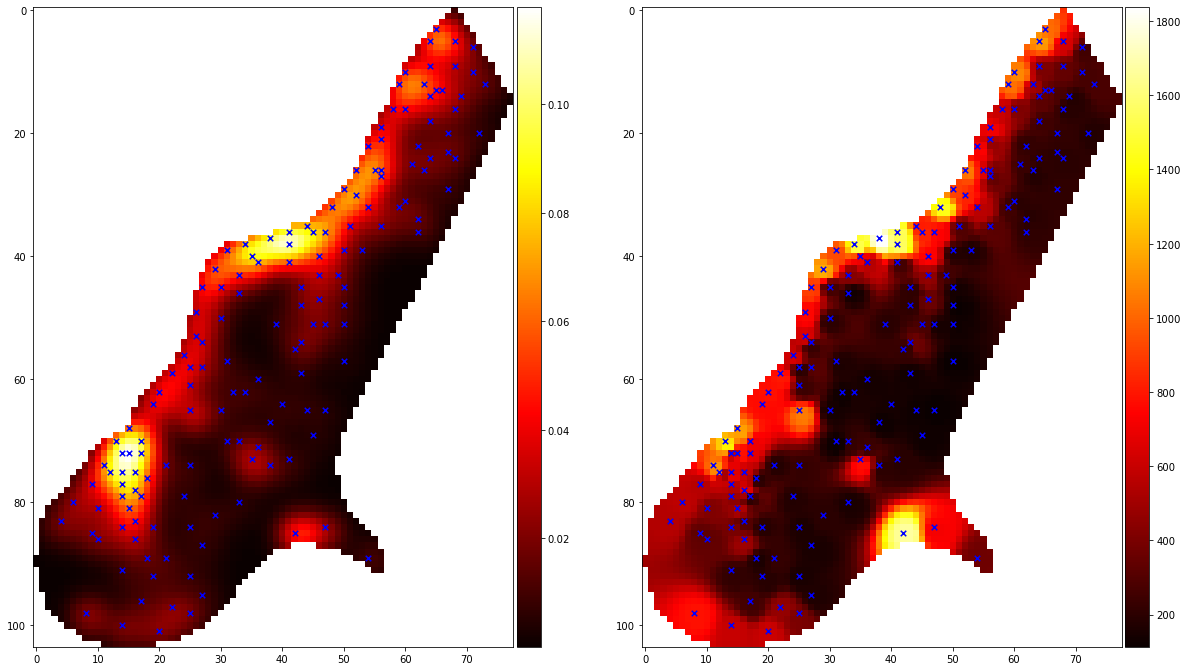

In [12]:
show_raster_map_grid([kde_array, idw_array], mask_array, data_coordinates=data_coordinates)



# Aufgabe 4: Splatting (Bonus)
In den letzten Übungen haben wir uns mit Trajektoriendaten beschäftigt. Das Zeichnen von einer grossen Menge an Trajektoriendaten wird in der Praxis schnell unübersichtlich. Hier sind Beispieldaten aus dem Geolife Datensatz. Einem frei verfügbaren GPS Datensatz bei dem die Bewegungen von Mitarbeitern von Microsoft Research in Peking über mehrere Monate hinweg aufgezeichnet wurden. Der Datensatz ist [frei verfügbar](https://www.microsoft.com/en-us/download/details.aspx?id=52367).

(4450000.0, 4400000.0)

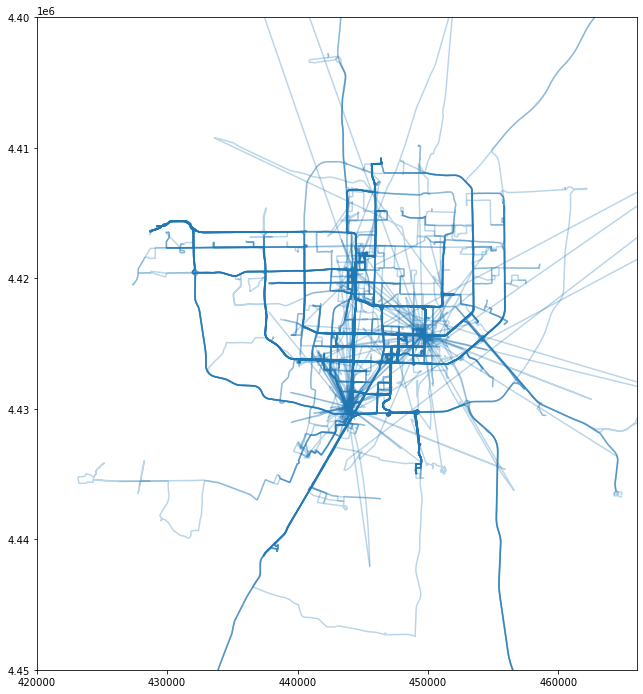

In [13]:
crs_wgs = 'epsg:4326'
crs_2D = 'epsg:32650'
tpls_all = gpd.read_file(os.path.join('data','shp', 'geolife_triplegs.shp'))
tpls_all = tpls_all.to_crs(crs_2D)

xmin = 420000
xmax = 466000
ymin = 4450000
ymax = 4400000

tpls_all.plot(figsize=(12,12), alpha=0.3)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))

### 4.1 Tranformation der Trajektoriendaten
Eine Möglichkeit Trajektoriendaten zu visualieren ist Edge-Splatting. Ähnlich zu der oben durchgeführten KDE wird hierbei eine Trajektorie mit einer Kernelfunktion "abgefahren". Dies ist vergleichbar damit, die Trajektorie in regelmässigen Abständen abzutasten und mit den Abtastpunkten das gleiche KDE verfahren wie in Aufgabe 1 durchzuführen.
Dafür müssen sie das Trajektorien aus dem  Geopandas Dataframe in eine liste mit Koordinatentupeln transformieren.

__Achtung__: Bei Trajektorien sammeln sich schnell grosse Datenmengen an! Nutzen Sie `tpls_all.sample(10)`, um mit wenigen Daten effizient testen zu können.


In [14]:
tpls = tpls_all.sample(5)
points_buff = map(lambda x: list(zip(x[1]['geometry'].coords.xy[0], x[1]['geometry'].coords.xy[1])),  tpls.iterrows())
points = []
list(map(points.extend, points_buff))
print(len(points))

2650


### 4.2 Berechnung des Edge-Splattings
Wenn die Punkte aus den Trajektorien extrahiert wurden, können wir das Edgesplatting ähnlich wie in der Hauptfunktion von Aufgabe 1 berechnen.

#### Hinweise: 
- Sie können die Auflösung (über die Anzahl an Pixeln in x und y Richtung selbst definieren. Benutzen Sie zu Beginn maximal eine Auflösung von 50x50. Eine Erhöhung übersteigt schnell die Rechenzeit!
- Für den neuen Datensatz brauchen wir später eine neue Pixel-zu-Koordinaten Transformationsfunktion. Diese haben wir Ihnen bereits vorgegeben.
- Nutzen Sie unbedingt tqdm(range(nb_pixels_y)) in der äussersten Schleife um ein Gefühl für die Rechenzeit des Algorithmus zu bekommen.


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.16it/s]


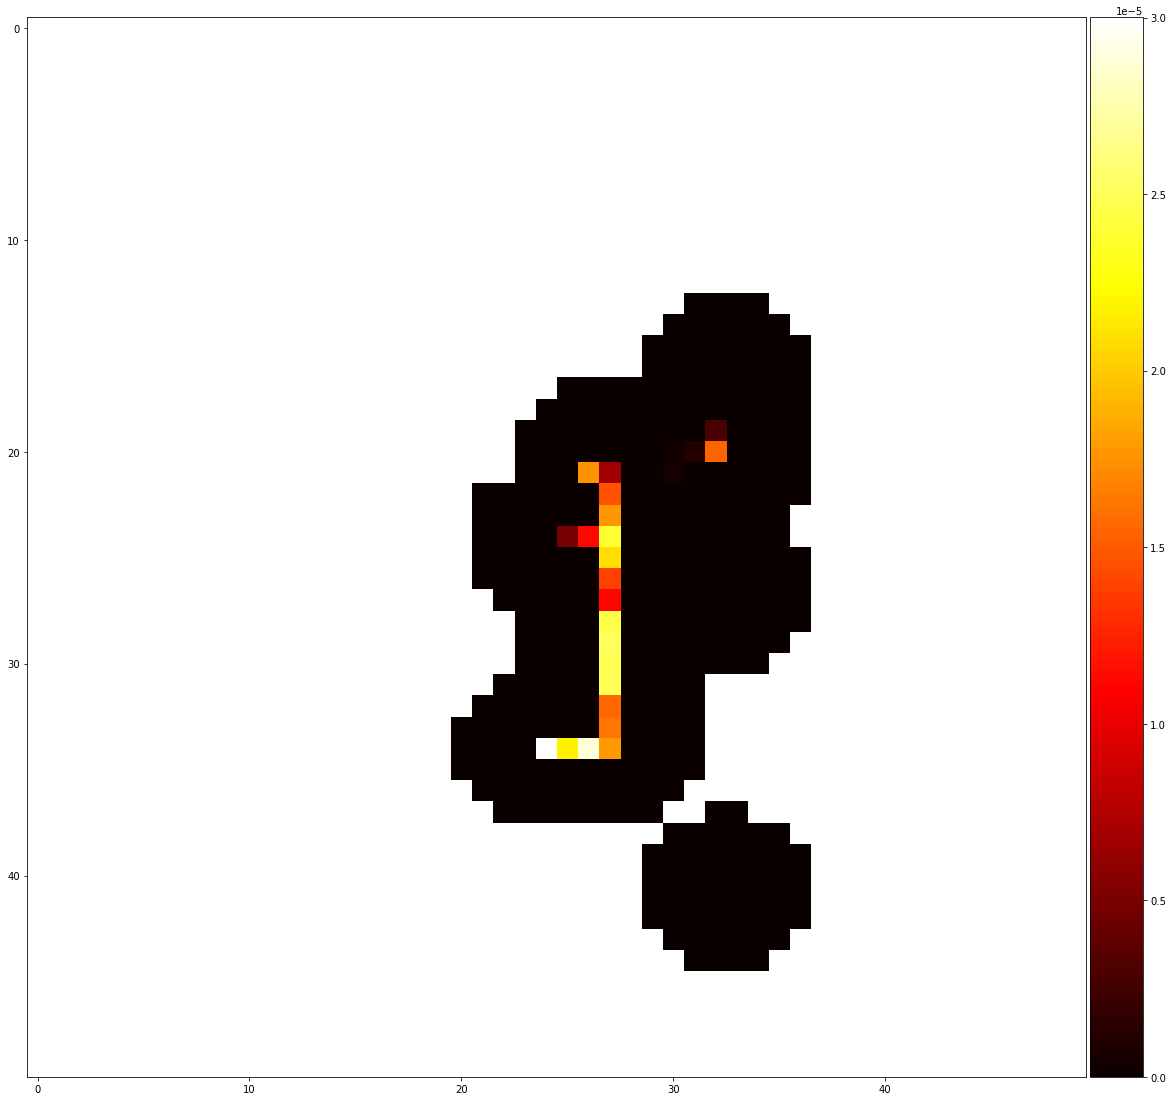

In [15]:
# create transformation

nb_pixels_x = 50
nb_pixels_y = 50


fwd_geolife = get_transform(xmax, xmin, ymax, ymin, nb_pixels_x, nb_pixels_y)

# calculate splatting
kde_array_splat = np.zeros((nb_pixels_x ,nb_pixels_y)) 

# Iterate through the ones array and consider just the values which are not no_data
for y in tqdm(range(nb_pixels_y)):
    for x in range(nb_pixels_x):
            
        kde_array_splat[y][x] = kde(cell_position=(x,y), data_coordinates=points, data_values=np.ones(len(points)),
                                  h=100, pixel_to_coords_transform=fwd_geolife)

kde_array_splat[kde_array_splat <= 0] = np.nan
show_raster_map_grid([kde_array_splat])
        

###  Aufgabe 5: Effiziente Kernel Density Estimation mithilfe des Nearest Neighbours Algorithmus
Sie werden bei der Aufgabe festgestellt haben, dass die Rechenzeit bereits für nur 10 Trajektorien und eine sehr grobe räumliche Auflösung untragbar gross ist. Das liegt vor allem an der ineffizienten Berechnung. In unserer `kde` Funktion wird für jeden Pixel jeder verfügbare Datenpunkt angesehen und fliesst mit in die Berechnung ein, egal wie weit er weg ist. Diese Genauigkeit und Gründlichkeit hat in der Praxis kaum Vorteile, da die nächsten Nachbarn in der Regel den grössten Einfluss haben. Mit einer sehr einfachen NN basierten Anpassung lässt sich der Rechenaufwand schnell um mehrere Grössenordnungen reduzieren. 

Hinweise:
- Verwenden Sie Klasse [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors) aus dem scikit-learn Paket. Verwenden Sie ein Objekt dieser Klasse um einen Index für die `data_coordinates` zu erstellen.
- Im Anschluss können Sie sich über `distances, indices = nbrs.kneighbors(cell_coordinates)` die Distanzen zu den n nächsten Nachbarn ausgeben lassen. Im Anschluss können Sie über den Array `distances` iterieren anstatt die Distanz zu allen Datenpunkten auszurechnen.


In [16]:

def kde_nn(cell_position, data_coordinates, nn, n_neighbors=5,  h=100, pixel_to_coords_transform=fwd, weight=1):
    """
    Computes the kernel density estimate at a cell position. 
    :param pixel_coordinates: A tuple or list containing a coordinate pair in pixel coordinates.
    :param data_points: List of x-y coordinate tuples of the data_values in EPGS:28992
    :param data_values: List of data values used for weighting the results
    :param fwd: The Affine object by which the forward transformation can be executed
    :return: The result that should be written into the corresponding pixel
    """
    # Convert the pixel coordinates to real coordinates by using the fwd transformation
    cell_coordinates = pixel_to_coords_transform * cell_position
    
    # Set important values and set n and sum to zero
    running_sum = 0
    
    # Iterate through all points of the point feature data set, compute the weight by using the formula for 
    # the kernel, and sum it up
    n = n_neighbors
    
    distances, indices = nbrs.kneighbors(np.asarray(cell_coordinates).reshape(1,2))
    
    for d in distances[0]: 
        u_i = weight
        
        
        u = d / h
        K_u = 1 / math.sqrt(2 * math.pi) * math.exp(-math.pow(u, 2) / 2)
        running_sum +=  K_u * u_i
        
    # Last step of KDE: Apply the formula to the determined sum and return the result
    result = ((1 / (n * h)) * running_sum)
    return result



Kopieren Sie hier die Hauptfunktion aus Aufgabe 4 und passen Sie sie so an, dass das NN Objekt erstellt wird  Im Anschluss muss hier 

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.30it/s]


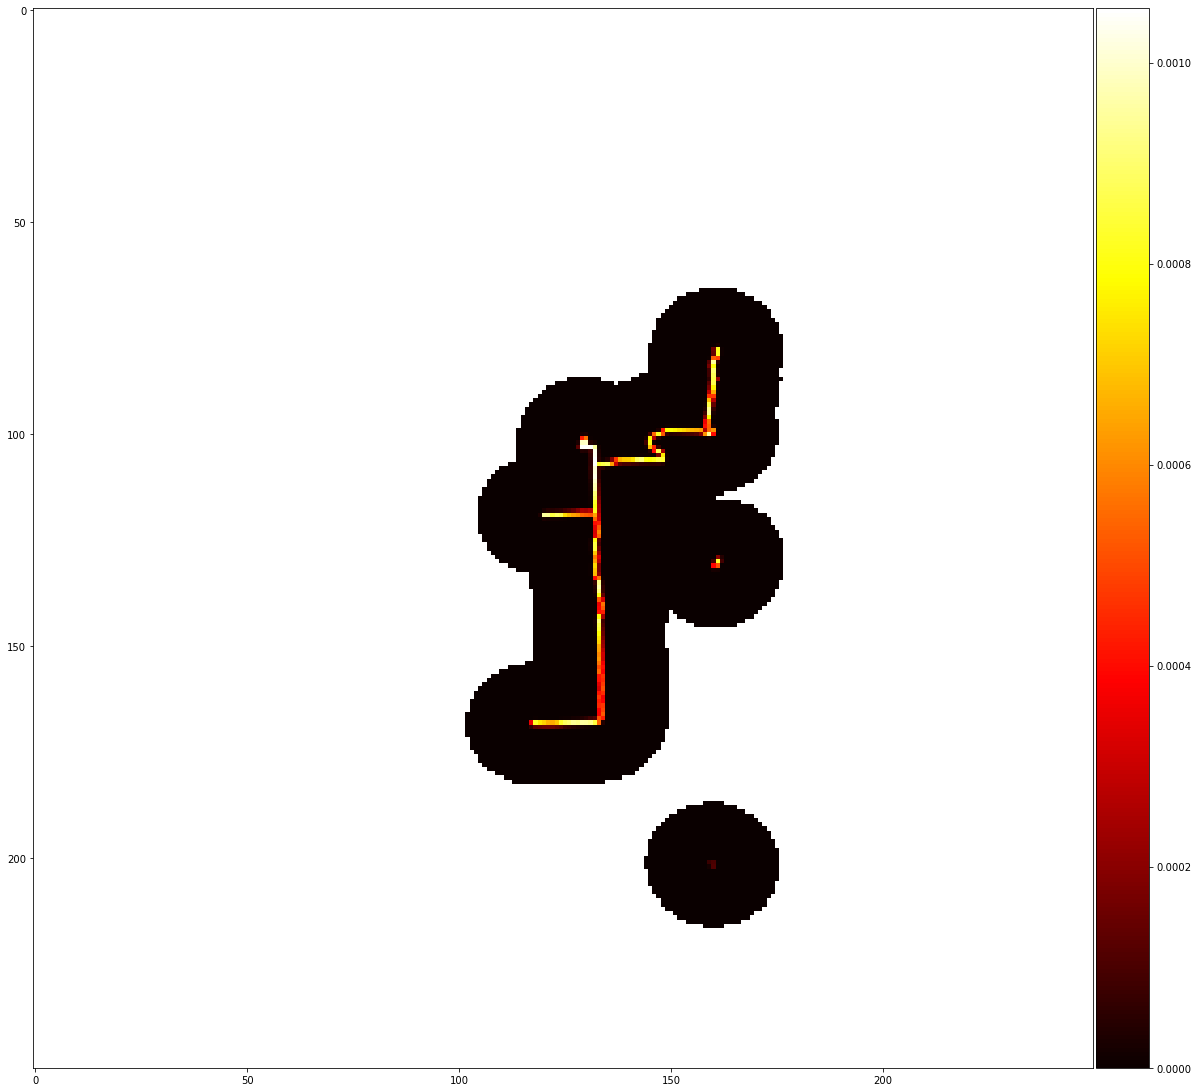

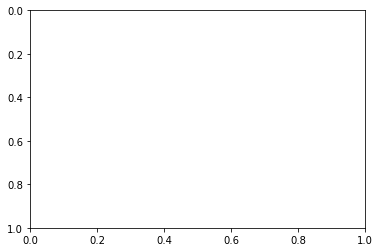

In [17]:
# create transformation

nb_pixels_x = 250
nb_pixels_y = 250

fwd_geolife = get_transform(xmax, xmin, ymax, ymin, nb_pixels_x, nb_pixels_y)


# fit nearest neighbours
nbrs = NearestNeighbors(n_neighbors=10).fit(points)
kde_array_splat_nn = np.zeros((nb_pixels_x ,nb_pixels_y))

# Iterate through the ones array and consider just the values which are not no_data
for y in tqdm(range(nb_pixels_y)):
    for x in range(nb_pixels_x):
            
        kde_array_splat_nn[y][x] = kde_nn(cell_position=(x,y), data_coordinates=points, nn=nbrs, n_neighbors=50, \
                                       h=75, pixel_to_coords_transform=fwd_geolife)
        
kde_array_splat_nn[kde_array_splat_nn <= 0] = np.nan
show_raster_map_grid([np.log(kde_array_splat_nn+1)])
